# Drift Dispersion Relation Solver by Superstatistics Integral(Kappa Distribution)

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy
import scipy.signal
from scipy import special as sp
import scipy.optimize as op
from scipy import integrate
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
kappa_e = 3.0
kappa_i = 3.0

mi2me = 1836
ve2vi = 100
kz_rho_i = 1e-3

Ln2rho_i = 10
wp_i2wc_i = 100

In [4]:
def PDRM(w2wc,ky_rho_i):
    Te2Ti = ve2vi**2/mi2me
    ky_rho_e = ky_rho_i*np.sqrt(Te2Ti/mi2me)
    kz_rho_e = kz_rho_i*np.sqrt(Te2Ti/mi2me)
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*np.sqrt(Te2Ti)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/np.sqrt(mi2me)/np.sqrt(Te2Ti)
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz
    zeta_ne = -zeta_ni*np.sqrt(Te2Ti)/np.sqrt(mi2me)
    
    re = 1 + (zeta_e-zeta_ne)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*np.i0(ky_rho_e**2)*np.exp(-ky_rho_e**2)
    ri = 1 + (zeta_i-zeta_ni)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*np.i0(ky_rho_i**2)*np.exp(-ky_rho_i**2)
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRK(w2wc,ky_rho_i,kappa_e):
    ae2ai = (kappa_e-1.5)/kappa_e * kappa_i/(kappa_i-1.5)
    he2hi = (kappa_e-1.5)/(kappa_e-0.5) * (kappa_i-0.5)/(kappa_i-1.5)
    
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    kz_rho_e = kz_rho_i*ve2vi/mi2me
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*np.sqrt(kappa_i/(kappa_i-0.5))
    k_l_De = k_l_Di*np.sqrt(ve2vi**2/mi2me/ae2ai*he2hi)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz*kappa_i/(kappa_i-1.5)
    zeta_ne = -zeta_ni*ve2vi/mi2me/ae2ai
    
    integrad_e1 = lambda be: np.sqrt(be)*zeta_e *plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_e2 = lambda be: np.sqrt(be)*zeta_ne*plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_i1 = lambda bi: np.sqrt(bi)*zeta_i *plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    integrad_i2 = lambda bi: np.sqrt(bi)*zeta_ni*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    
    terms = 100
    gl_e1 = sp.roots_genlaguerre(terms,kappa_e-0.5)
    gl_e2 = sp.roots_genlaguerre(terms,kappa_e-1.5)
    gl_i1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
    gl_i2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
    
    i_e1 = np.dot(gl_e1[1],integrad_e1(gl_e1[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    i_e2 = np.dot(gl_e2[1],integrad_e2(gl_e2[0]/kappa_e))/sp.gamma(kappa_e+0.5)*(kappa_e-1.5)
    i_i1 = np.dot(gl_i1[1],integrad_i1(gl_i1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    i_i2 = np.dot(gl_i2[1],integrad_i2(gl_i2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)
    
    re = 1 + i_e1-i_e2
    ri = 1 + i_i1-i_i2
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

#dispersion for kappa_i = infty
def PDRKM(w2wc,ky_rho_i,kappa_e):
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    kz_rho_e = kz_rho_i*ve2vi/mi2me
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*np.sqrt(ve2vi**2/mi2me*kappa_e/(kappa_e-0.5))
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz
    zeta_ne = -zeta_ni*ve2vi/mi2me*kappa_e/(kappa_e-1.5)
    
    integrad_e1 = lambda be: np.sqrt(be)*zeta_e *plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_e2 = lambda be: np.sqrt(be)*zeta_ne*plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    
    terms = 100
    gl_e1 = sp.roots_genlaguerre(terms,kappa_e-0.5)
    gl_e2 = sp.roots_genlaguerre(terms,kappa_e-1.5)
    
    i_e1 = np.dot(gl_e1[1],integrad_e1(gl_e1[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    i_e2 = np.dot(gl_e2[1],integrad_e2(gl_e2[0]/kappa_e))/sp.gamma(kappa_e+0.5)*(kappa_e-1.5)
    
    re = 1 + i_e1-i_e2
    ri = 1 + (zeta_i-zeta_ni)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*np.i0(ky_rho_i**2)*np.exp(-ky_rho_i**2)
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [5]:
ktest = 1e-3

#for ky_rho_i = 1e-3 kz_rho_i = 1e-3 kappa_e = kappa_i = 3
wguess_m = -0.004
rguess_m = 0.001
wguess_k = -0.004
rguess_k = -0.001

s=op.root(lambda w:PDRM(w,ktest),[wguess_m,rguess_m])
print('M',s.success)
print(s.x[0],s.x[1])

s1=op.root(lambda w:PDRK(w,ktest,kappa_e),[wguess_k,rguess_k])
print('K',s1.success)
print(s1.x[0],s1.x[1])

s2=op.root(lambda w:PDRKM(w,ktest,kappa_e),[wguess_k,rguess_k])
print('KM',s2.success)
print(s2.x[0],s2.x[1])

M True
-0.003289228369459323 -0.00017495953329234573
K True
-0.0036214968771089012 -0.0005892551941001024
KM True
-0.0035075527368311444 -0.00013768938010436774


In [6]:
ky_rho_i_list = np.linspace(0.001,0.2,num=800)
kappa_e_list = np.geomspace(2,8,num=100)
ky_rho_i_lim_list1 = []

for kappa_e_each in tqdm(kappa_e_list):
    wgkm =wguess_k
    rgkm =rguess_k
    for ki in ky_rho_i_list:
        sKM=op.root(lambda w:PDRKM(w,ki,kappa_e_each),[wgkm,rgkm])
        if rgkm<=0 and sKM.x[1]>0:
            ky_rho_i_lim = ki - 0.5*(ky_rho_i_list[1]-ky_rho_i_list[0])
            ky_rho_i_lim_list1.append(ky_rho_i_lim)
            break
        wgkm = sKM.x[0]
        rgkm = sKM.x[1]
        if ki==ky_rho_i_list[-1]:
            ky_rho_i_lim_list1.append(np.nan)

100%|██████████| 100/100 [06:15<00:00,  3.75s/it]


In [7]:
print(np.count_nonzero(np.isnan(ky_rho_i_lim_list1)))

0


In [8]:
kappa_i = 4
ky_rho_i_lim_list2 = []

for kappa_e_each in tqdm(kappa_e_list):
    wgk =wguess_k
    rgk =rguess_k
    for ki in ky_rho_i_list:
        sK=op.root(lambda w:PDRK(w,ki,kappa_e_each),[wgk,rgk])
        if rgk<=0 and sK.x[1]>0:
            ky_rho_i_lim = ki - 0.5*(ky_rho_i_list[1]-ky_rho_i_list[0])
            ky_rho_i_lim_list2.append(ky_rho_i_lim)
            break
        wgk = sK.x[0]
        rgk = sK.x[1]
        if ki==ky_rho_i_list[-1]:
            ky_rho_i_lim_list2.append(np.nan)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [10:35<00:00,  6.36s/it]


In [9]:
print(np.count_nonzero(np.isnan(ky_rho_i_lim_list2)))

0


In [10]:
kappa_i = 2
ky_rho_i_lim_list3 = []

for kappa_e_each in tqdm(kappa_e_list):
    wgk =wguess_k
    rgk =rguess_k
    for ki in ky_rho_i_list:
        sK=op.root(lambda w:PDRK(w,ki,kappa_e_each),[wgk,rgk])
        if rgk<=0 and sK.x[1]>0:
            ky_rho_i_lim = ki - 0.5*(ky_rho_i_list[1]-ky_rho_i_list[0])
            ky_rho_i_lim_list3.append(ky_rho_i_lim)
            break
        wgk = sK.x[0]
        rgk = sK.x[1]
        if ki==ky_rho_i_list[-1]:
            ky_rho_i_lim_list3.append(np.nan)

100%|██████████| 100/100 [10:05<00:00,  6.05s/it]


In [11]:
print(np.count_nonzero(np.isnan(ky_rho_i_lim_list3)))

0


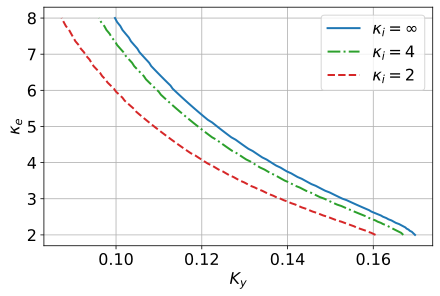

In [12]:
fig = plt.figure(figsize=(6,4),layout='constrained')

plt.plot(ky_rho_i_lim_list1,kappa_e_list,color='tab:blue',linestyle='-',label=r'$\kappa_i=\infty$')
plt.plot(ky_rho_i_lim_list2,kappa_e_list,color='tab:green',linestyle='-.',label=r'$\kappa_i=4$')
plt.plot(ky_rho_i_lim_list3,kappa_e_list,color='tab:red',linestyle='--',label=r'$\kappa_i=2$')
plt.xlabel(r'$K_y$')
plt.ylabel(r'$\kappa_e$')
plt.legend()
plt.grid()
plt.savefig('./fig3_kyrhoi_lim.pdf')
plt.show()